# Tarea 2: Random Forest
<hr/>

### Nombre: Benjamín Farías V.

## Librerías

A continuación se importan las librerías necesarias para la tarea:

In [1]:
# Se importan las librerías necesarias
import numpy as np
import pandas as pd
from IPython.display import Image # Se usa para la visualización
import pydotplus # Se usa para la visualización
# Requiere tener instalado graphviz (tanto a través del pip como con su instalador ejecutable) y que la carpeta 'bin/' 
# del directorio donde se instaló graphviz pertenezca al PATH del sistema

## Cargar Base de Datos

Aquí se carga la base de datos, con la opción de limitar la cantidad de filas en caso de que sea necesario un testing rápido:

In [2]:
# Se carga la base de datos, con la opción de limitar la cantidad de filas a analizar para una ejecución más rápida
def load_database(path, limit):
    db = pd.read_csv(path, nrows=limit)
    return db

db = load_database('FATS_GAIA.dat', None)
print(list(db)) # Se muestran los nombres de todas las columnas de la base de datos

['Amplitude', 'AndersonDarling', 'Autocor_length', 'Class', 'Con', 'Eta_e', 'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_0', 'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2', 'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3', 'ID', 'LinearTrend', 'MaxSlope', 'Mean',

Podemos ver que una de las columnas representa el ID de los datos. Como este atributo no aporta ninguna información sobre los datos en sí, se elimina de la base de datos a utilizar:

In [3]:
dataset = db.drop('ID', axis=1)
dataset.head()

,Amplitude,AndersonDarling,Autocor_length,Class,Con,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,...,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std
0,1.416432,0.949482,3.0,MIRA_SR,0.000000,5.442293,0.243054,0.462373,0.653511,0.761790,...,268.331543,0.025528,0.304804,0.310355,1.784879,0.304804,0.011895,19.899170,-1.266215,0.931676
1,0.443386,1.000000,1.0,RRAB,0.000000,12042.752633,0.162446,0.231268,0.517775,0.720122,...,0.508910,0.012390,0.309458,0.519645,0.397205,0.258203,-0.962335,0.147949,-0.183573,0.284637
2,0.170099,0.875986,4.0,MIRA_SR,0.030303,137.020266,0.033964,0.208724,0.378623,0.501416,...,8.742769,0.040022,0.342646,0.700200,0.119849,0.368936,0.472161,0.147949,0.064528,0.089020
3,1.350858,0.999869,4.0,MIRA_SR,0.000000,23.583559,0.259476,0.593270,0.613808,0.817245,...,379.949707,0.000843,0.349687,0.285682,1.867060,0.349687,-0.047072,23.597900,-1.454570,0.926506
4,0.248472,0.999947,3.0,MIRA_SR,0.000000,125.486491,0.202240,0.448444,0.565120,0.606539,...,318.427795,0.022169,0.247451,0.578087,0.273482,0.247451,0.594605,0.147949,-0.689124,0.153349


## Generar Sets de Entrenamiento y Testing

Se utiliza la función `sample()` de Pandas para generar un set de entrenamiento pseudo-aleatorio (controlado por el parámetro random_state). El resto de las filas de la base de datos se utilizan para formar el set de testing:

In [4]:
train = dataset.sample(frac=0.8, random_state=8)
test = dataset.drop(train.index)
train.head()

,Amplitude,AndersonDarling,Autocor_length,Class,Con,Eta_e,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,...,PeriodLS,Period_fit,Psi_CS,Psi_eta,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std
184247,0.122600,1.000000,2.0,MIRA_SR,0.046512,65.412801,0.007967,0.028080,0.039311,0.181164,...,258.779907,0.006344,0.267948,0.424538,0.008834,0.267948,2.773857,0.147949,8.664289,0.072231
150468,0.115256,0.991894,4.0,MIRA_SR,0.000000,8481.065264,0.295922,0.442031,0.638927,0.837584,...,4.983892,0.081077,0.309404,0.814876,0.105298,0.293389,-0.589454,0.665771,-0.204533,0.063245
56018,0.128065,1.000000,3.0,MIRA_SR,0.000000,105.669197,0.513007,0.586750,0.659246,0.707679,...,226.498581,0.000130,0.301160,0.710347,0.155854,0.311928,-0.609022,9.912598,1.457195,0.094129
144791,0.112717,0.999916,1.0,DSCT_SXPHE,0.000000,18204.812007,0.183959,0.364300,0.486949,0.570208,...,3.757803,0.385018,0.305149,1.519323,0.100901,0.234361,-0.712594,0.295898,-0.521013,0.070381
50593,0.228990,1.000000,3.0,MIRA_SR,0.064516,393.640375,0.070372,0.145384,0.193833,0.268867,...,940.546875,0.081496,0.308698,0.251574,0.093917,0.308698,1.834930,0.147949,3.160394,0.130923


## Entrenamiento

Se genera el Random Forest (Bosque Aleatorio) a partir del set de entrenamiento mediante la función `fit()`, que a su vez utiliza una variedad de funciones auxiliares para organizar mejor el código. Los parámetros que recibe la función `fit()` son los siguientes:

- data_train: Corresponde al set de entrenamiento a utilizar (pandas DataFrame).
- data: Una lista que contiene los nombres de todas las variables predictoras (atributos).
- target: El nombre de la variable que se busca predecir.
- n_estimators: La cantidad de árboles de decisión del Random Forest, por default es 10.
- max_depth: La profundidad máxima de los árboles, por default es 10 (al aumentarla escala bastante el tiempo de entrenamiento).
- min_samples_split: La cantidad mínima de datos que debe tener un nodo para poder realizar el split, por default es 2.
- criterion: El criterio de impureza a utilizar sobre los datos. Por default se utiliza la 'Impureza de Gini' (criterion='gini'), mientras que también se puede usar la 'Entropía' (criterion='entropy'). Ésta última es un poco más lenta.
- num_intervals: Indica la cantidad de intervalos en los que se separan los valores continuos de cada atributo, para después compararlos y elegir el punto que tenga los datos más homogéneos como 'representante' de la impureza de dicho atributo. Por default es 2, lo que significa que para cada variable continua se calcula la ganancia de información con respecto al nodo actual simplemente separando por la mediana de sus valores (si fuese 4, se obtendrían y compararían los 3 cuartiles, eligiendo el que mejor separa el atributo).
- min_gain: Indica la ganancia mínima de información para poder realizar el split de cada nodo (si no cumple con el mínimo entonces se transforma en un nodo hoja).

In [ ]:
# Divide los valores de un atributo continuo en k intervalos y determina el que mejor separa los datos
def find_split_point(node, feature, target, k, criterion):
    points = node['samples'][feature].quantile(q=k) # Se calculan los k cuantiles
    min_impurity = float('inf')
    best_nodes = []
    best_split_point = 0
    for point in points: # Se itera sobre cada punto (cuantil), calculando la impureza al separar usando dicho punto
        split_a = node['samples'][node['samples'][feature] <= point]
        split_b = node['samples'][node['samples'][feature] > point]
        node_a = {'depth': node['depth'] + 1, 'samples': split_a, 'condition': [], 'children': [], 'prediction': None}
        node_b = {'depth': node['depth'] + 1, 'samples': split_b, 'condition': [], 'children': [], 'prediction': None}
        a_impurity = (len(node_a['samples']) / len(node['samples'])) * calculate_impurity(node_a, target, criterion)
        b_impurity = (len(node_b['samples']) / len(node['samples'])) * calculate_impurity(node_b, target, criterion)
        split_impurity = a_impurity + b_impurity # Representa la impureza ponderada entre los nodos hijos
        if split_impurity < min_impurity: # Se busca minimizar la impureza al elegir el punto de separación de los datos
            min_impurity = split_impurity
            best_nodes = [node_a, node_b]
            best_split_point = point
    return min_impurity, best_nodes[0], best_nodes[1], best_split_point # Punto de separación elegido para este atributo

# Calcula la impureza de los datos (puede utilizar el criterio Gini o de Entropía)
def calculate_impurity(node, target, criterion):
    values = np.array(node['samples'][target].value_counts())
    if criterion == 'entropy': # Entropía
        entropy_f = lambda x: - (x / len(node['samples'])) * np.log2(x / len(node['samples']))
        return np.sum(entropy_f(values))
    else: # Gini
        gini_f = lambda x: (x / len(node['samples'])) ** 2
        return 1 - np.sum(gini_f(values))

# Expande un nodo según el atributo que divide mejor los datos
def split_node(node, data, target, criterion, num_intervals, min_gain, feature_imp):
    if len(node['samples'][target].value_counts()) == 1: # Revisa si todas las filas tienen el mismo valor para el target
        return [] # Si esto ocurre entonces NO se expande el nodo (criterio de detención)
    impurity = calculate_impurity(node, target, criterion) # Impureza de los datos en el nodo actual
    data_fraction = (1 / num_intervals)
    # Cuantiles candidatos para dividir los valores de cada atributo (si num_intervals=4, entonces serían los 3 cuartiles)
    intervals = [round(n * data_fraction, 2) for n in range(1, num_intervals)]
    best_split = []
    best_feature = data[0]
    best_split_point = 0
    max_gain = 0
    for feature in data: # Se busca el atributo que mejor separa los datos
        # Obtiene el mejor punto de separación de un atributo 
        # (entre la cantidad de cuantiles indicada en el parámetro num_intervals)
        split_impurity, node_a, node_b, split_point = find_split_point(node, feature, target, intervals, criterion)
        gain = impurity - split_impurity # Ganancia de información en los datos para este atributo
        if gain > max_gain: # Se busca maximizar la ganancia de información al elegir el atributo de separación de los datos
            max_gain = gain
            best_split = [node_a, node_b]
            best_feature = feature
            best_split_point = split_point
    if max_gain <= min_gain: # NO se expande el nodo si no cumple con la ganancia mínima de información
        return []
    node['condition'] = [best_feature, best_split_point] # Se guarda la condición del split en el nodo para utilizarla después
    node['samples'] = len(node['samples']) # Se guarda la cantidad de datos del nodo para visualizarla 
    # (y ahorrar memoria dejando de apuntar al dataset que ya no será utilizado)
    node['impurity'] = impurity # Se guarda la impureza para visualizarla
    feature_imp[best_feature] += max_gain # Se añade la ganancia generada por el mejor atributo de este split
    return best_split

# Genera un árbol de decisión a partir de un dataset
def generate_tree(dataset, data, target, max_depth, min_samples_split, criterion, num_intervals, min_gain):
    tree = {0: {'depth': 0, 'samples': dataset, 'condition': [], 'children': [], 'prediction': None}} # Árbol inicial
    feature_imp = {x: 0 for x in data} # Acumula la ganancia de información generada por cada variable
    index = 1
    nodes = [tree[0]]
    while nodes: # Se utiliza DFS para generar los nodos del árbol (ocupa menos memoria que BFS)
        current = nodes.pop()
        new_nodes = []
        # Se revisa si se ha alcanzado la profundidad máxima y si se cumple con el mínimo de muestras para hacer el split
        if (current['depth'] < max_depth) and (len(current['samples']) >= min_samples_split):
            # Se eligen los atributos candidatos para expandir el nodo actual de manera aleatoria 
            # (se utiliza el criterio de la raíz cuadrada para elegir la cantidad de estos)
            chosen_features = np.random.choice(data, size=int(np.ceil(np.sqrt(len(dataset.columns) - 1))), replace=False)
            # Se expande el nodo actual
            new_nodes = split_node(current, chosen_features, target, criterion, num_intervals, min_gain, feature_imp)
            for node in new_nodes: # Se añaden los nuevos nodos al árbol
                tree[index] = node
                current['children'].append(index)
                nodes.append(tree[index])
                index += 1
        if not new_nodes: # Se deja de expandir la rama (nodo hoja)
            prediction = current['samples'][target].value_counts().index.tolist()
            current['prediction'] = prediction[0] # Se asigna el valor más común de la clase como predicción
            current['impurity'] = calculate_impurity(current, target, criterion) # Se guarda la impureza para visualizarla
            current['samples'] = len(current['samples']) # Se guarda la cantidad de datos del nodo para visualizarla
    return tree, feature_imp

# Función que genera el Random Forest a partir del set de entrenamiento
def fit(data_train, data, target, n_estimators=10, max_depth=10, min_samples_split=2, criterion='gini',
        num_intervals=2, min_gain=0):
    forest = np.array([])
    feature_importance = np.array([])
    for n in range(n_estimators):
        bagging = data_train.sample(frac=1, replace=True) # Bootstrap Aggregation (Bagging), del mismo tamaño que el dataset
        # Genera un árbol de decisión y calcula la importancia de cada feature en dicho árbol
        tree, features = generate_tree(bagging, data, target, max_depth, min_samples_split, criterion, num_intervals, min_gain)
        forest = np.append(forest, tree) # Se añade el árbol al Random Forest
        feature_importance = np.append(feature_importance, features) # Se añade la importancia de cada feature para este árbol
    return forest, feature_importance

data = list(train) # Variables predictoras
data.remove('Class')
# Random Forest generado (se recomienda esta configuración)
random_forest, feature_importance = fit(train, data, 'Class', min_samples_split=80, num_intervals=3, min_gain=0.005)

## Testing

Se aplica el modelo generado con el set de entrenamiento sobre el set de testing, utilizando la función `predict()`. Los parámetros que recibe esta función son los siguientes:

- forest: El Random Forest generado con la función `fit()`.
- data_test: El set de testing (pandas DataFrame).
- target: El nombre de la variable que se busca predecir.
- limit: Permite limitar la cantidad de filas a predecir del set de testing.

In [65]:
# Función que aplica el modelo clasificador sobre el set de testing
def predict(forest, data_test, target, limit=None):
    dataset = data_test
    if limit: # Se limita el dataset, en caso de que sea necesario
        dataset = data_test.head(limit)
    correct_predictions = 0
    results = {value: {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0} for value in dataset[target].value_counts().index.tolist()}
    for row in dataset.itertuples(): # Se itera sobre las filas del set de testing
        predictions = []
        for tree in forest: # Se itera sobre todos los árboles del Random Forest
            nodes = [tree[0]]
            while nodes: # Cada árbol es recorrido utilizando DFS
                current = nodes.pop()
                if current['prediction']: # Si se llega a un nodo hoja se obtiene la predicción
                    predictions.append(current['prediction'])
                else:
                    feature, split_point = current['condition'] # Si se llega a un nodo intermedio se sigue avanzando
                    if getattr(row, feature) <= split_point:
                        nodes.append(tree[current['children'][0]])
                    else:
                        nodes.append(tree[current['children'][1]])
        chosen_prediction = max(set(predictions), key=predictions.count) # Se obtiene la predicción final por mayoría de votos
        for value in results: # Se guardan los resultados para cada clase utilizando una matriz de confusión
            if value == getattr(row, target):
                if chosen_prediction == value:
                    results[value]['TP'] += 1
                    correct_predictions += 1
                else:
                    results[value]['FN'] += 1
            else:
                if chosen_prediction == value:
                    results[value]['FP'] += 1
                else:
                    results[value]['TN'] += 1
    total_accuracy = correct_predictions / len(dataset) # También se calcula la proporción total de predicciones correctas
    return results, total_accuracy

results, total_accuracy = predict(random_forest, test, 'Class') # Resultados (se utilizarán para el análisis)

## Visualización

A continuación se definen las funciones `generate_tree_graph()` (recibe como parámetro un árbol del Random Forest y genera un string con la información del árbol en 'DOT language' (lenguaje utilizado por `graphviz`)) y `display_tree()` (recibe el string generado por `generate_tree_graph()` y lo transforma en un archivo `.png` usando la librería `pydotplus` en conjunto con `graphviz`, para luego proceder a mostrarlo en el jupyter notebook). Ambas funciones también reciben un parámetro opcional para limitar la cantidad de nodos a visualizar, es importante que este tome el MISMO valor en ambas funciones (se recomienda utilizarlo, ya que de otra forma los árboles son muy grandes y se complica el revisarlos en detalle):

In [66]:
# Función que genera un string con la información del árbol seleccionado
def generate_tree_graph(tree, limit=float('inf')):
    dot_data = 'graph {' # String inicial
    for node, value in tree.items(): # Se itera sobre los nodos del árbol, añadiendo toda la información necesaria al string
        header = f'n{node} [style="rounded,filled", shape=box, '
        samples = value['samples']
        impurity = round(value['impurity'], 2)
        common_info = f'impurity = {impurity}\nsamples = {samples}"];'
        if value['prediction'] and (node <= limit): # Información de un nodo hoja
            prediction = value['prediction']
            dot_data += header
            dot_data += f'fillcolor=green, label="Class = {prediction}\n'
            dot_data += common_info
        elif node <= limit: # Información de un nodo intermedio
            color_dict = {300: 'cyan', 2000: 'blue', 20000: 'yellow', 150000: 'orange', 200000: 'red'}
            child_a = value['children'][0]
            child_b = value['children'][1]
            feature = value['condition'][0]
            threshold = round(value['condition'][1], 2)
            dot_data += header
            chosen_color = ''
            for value, color in color_dict.items(): # Asignación de colores en función del número de muestras
                if (not chosen_color) and (samples <= value):
                    chosen_color = color
            dot_data += f'fillcolor={chosen_color}, label="{feature} <= {threshold}\n'
            dot_data += common_info
            if not node:
                dot_data += f'n{node} -- n{child_a} [label="True"];n{node} -- n{child_b} [label="False"];'
            else:
                dot_data += f'n{node} -- n{child_a};n{node} -- n{child_b};'
    dot_data += '}'
    return dot_data # String completo

# Función que grafica el árbol de decisión
def display_tree(tree, limit=float('inf')):
    ret = limit > 50 # Si la cantidad de nodos es MENOR o IGUAL a 50 se le aplica 'Zoom' para ver con más detalle
    return Image(tree_graph.create_png(), retina=ret, unconfined=True) # Imagen '.png' del árbol

Se llama a las funciones de arriba para visualizar el árbol seleccionado (por default está puesto el primer árbol generado en el Random Forest). Los colores de los nodos están basados en el tamaño de sus datasets (con un par de excepciones), según lo siguiente:

- Rojo: 150001 - 200000 filas
- Naranjo: 20001 - 150000 filas
- Amarillo: 2001 - 20000 filas
- Azul: 301 - 2000 filas
- Celeste: 0 - 300 filas
- Verde: Nodos HOJA.
- Blanco: Nodos que NO se muestran en la visualización (debido al límite), pero están conectados a los que Sí se muestran.

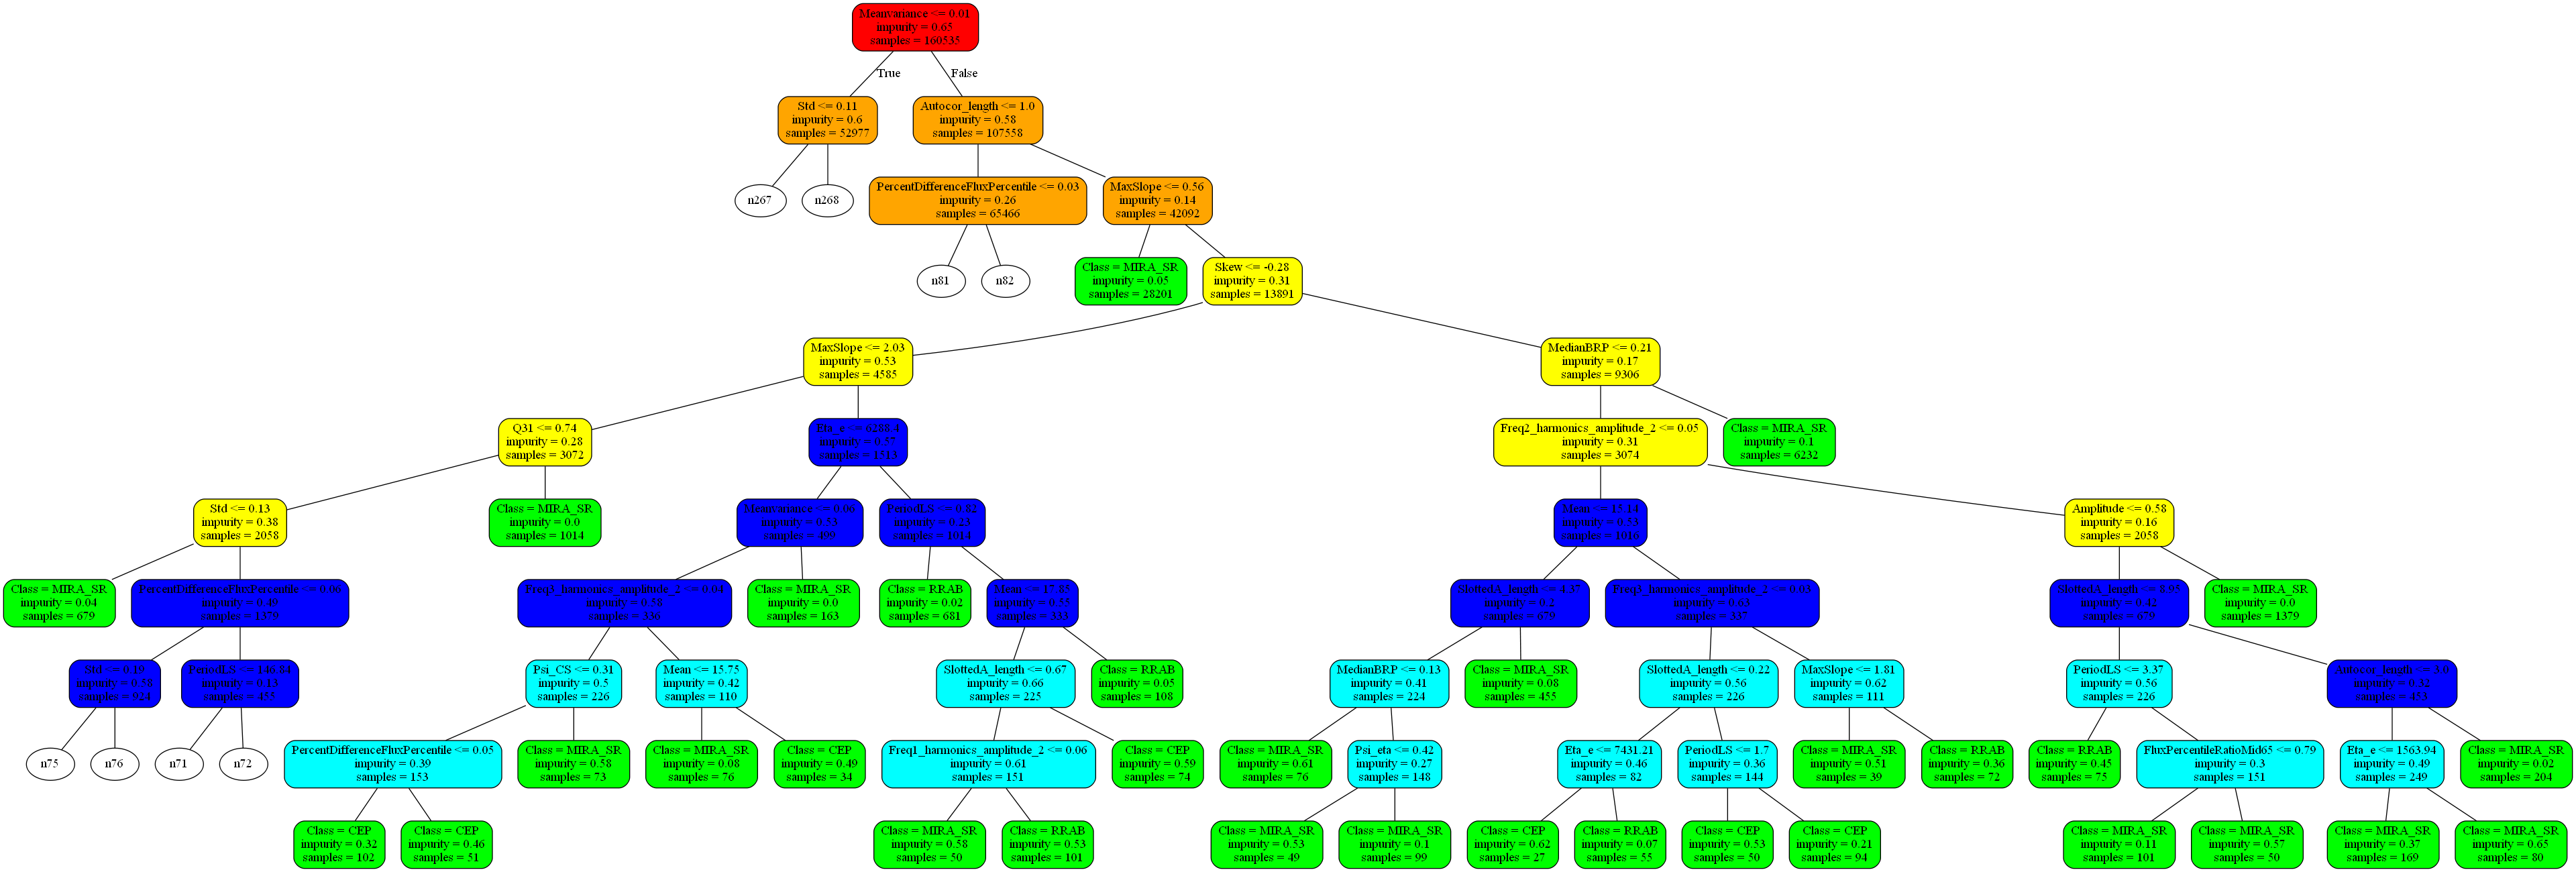

In [71]:
node_limit = 70 # Límite de nodos (si es menor o igual a 50 se ve con 'Zoom')
tree_data = generate_tree_graph(random_forest[0], node_limit) # Generar datos del árbol
tree_graph = pydotplus.graph_from_dot_data(tree_data)
display_tree(tree_graph.create_png(), node_limit) # Grafica el árbol (utiliza DFS para el orden de los nodos)

## Análisis

A continuación se muestra la proporción de predicciones correctas realizadas en el set de testing (Total Accuracy):

In [72]:
print(f'Total Accuracy: {total_accuracy}')

Total Accuracy: 0.9473015398415309


Para la configuración recomendada, el modelo entrenado logró predecir correctamente la variable 'Class' en aprox. el 95% de los datos del set de testing, probando ser un buen modelo clasificador. Aun así, esto NO entrega mucha información con respecto a la clasificación de cada uno de los valores que podía tomar la variable 'Class' de forma independiente, por lo que también se guardaron las cantidades que representan a una matriz de confusión (para cada valor posible de 'Class'). Estas cantidades son las siguientes:

- TP (Verdaderos Positivos): Corresponde a la cantidad de veces que el modelo clasifica CORRECTAMENTE un dato con el MISMO valor de la clase representada en la matriz.

- TN (Verdaderos Negativos): Corresponde a la cantidad de veces que el modelo clasifica CORRECTAMENTE un dato con un valor DISTINTO al de la clase representada en la matriz.

- FP (Falsos Positivos): Corresponde a la cantidad de veces que el modelo clasifica INCORRECTAMENTE un dato con el MISMO valor de la clase representada en la matriz.

- FN (Falsos Negativos): Corresponde a la cantidad de veces que el modelo clasifica INCORRECTAMENTE un dato con un valor DISTINTO al de la clase representada en la matriz.

Estas cantidades nos permiten calcular las siguientes métricas de interés:

- Accuracy: Corresponde a la proporción de predicciones correctas respecto a dicho valor de 'Class', es decir la proporción de verdaderos positivos y negativos en el dataset completo. Esta métrica es útil cuando el dataset se encuentra 'balanceado' (proporción similar de filas para cada valor posible de 'Class').

- Precision: Indica qué tan precisas fueron las predicciones para un cierto valor de 'Class', es decir, a medida que disminuye la cantidad de falsos positivos la precisión aumenta.

- Recall: Indica qué tan amplio fue el alcance de las predicciones POSITIVAS para un cierto valor de 'Class', es decir, a medida que disminuye la cantidad de falsos negativos el recall aumenta.

- Specificity: Indica qué tan amplio fue el alcance de las predicciones NEGATIVAS para un cierto valor de 'Class', es decir, a medida que disminuye la cantidad de falsos positivos la specificity aumenta.

- F1 Score: Combina las métricas Precision y Recall mediante su promedio armónico, por lo que se utilizará esta métrica en el análisis.

A continuación se calculan y muestran los valores de estas métricas:

In [73]:
for key, value in results.items():
    accuracy = (value['TP'] + value['TN']) / (value['TP'] + value['TN'] + value['FP'] + value['FN'])
    if (value['TP'] + value['FP']):
        precision = value['TP'] / (value['TP'] + value['FP'])
    else:
        precision = 1.0
    if (value['TP'] + value['FN']):
        recall = value['TP'] / (value['TP'] + value['FN'])
    else:
        recall = 1.0
    if (value['TN'] + value['FP']):
        specificity = value['TN'] / (value['TN'] + value['FP'])
    else:
        specificity = 1.0
    if (precision + recall):
        f1_score = (2 * precision * recall) / (precision + recall)
    else:
        f1_score = 0.0
    print(f'Value: {key}, Accuracy: {round(accuracy, 3)}, Specificity: {round(specificity, 3)}, F1 Score: {round(f1_score, 3)}')

Value: MIRA_SR, Accuracy: 0.982, Specificity: 0.969, F1 Score: 0.979
Value: RRAB, Accuracy: 0.972, Specificity: 0.963, F1 Score: 0.965
Value: RRC, Accuracy: 0.982, Specificity: 0.991, F1 Score: 0.913
Value: CEP, Accuracy: 0.98, Specificity: 0.999, F1 Score: 0.528
Value: DSCT_SXPHE, Accuracy: 0.991, Specificity: 0.997, F1 Score: 0.805
Value: T2CEP, Accuracy: 0.993, Specificity: 1.0, F1 Score: 0.0
Value: RRD, Accuracy: 0.997, Specificity: 1.0, F1 Score: 0.0
Value: ACEP, Accuracy: 0.999, Specificity: 1.0, F1 Score: 0.0
Value: ARRD, Accuracy: 0.999, Specificity: 1.0, F1 Score: 0.0


Al observar los valores de Accuracy se puede ver que todos son muy altos (casi 100%), lo que también ocurre para la Specificity, por lo que el modelo no tiene problemas para detectar los casos NEGATIVOS. Por otro lado, el F1 Score es muy alto para los 3 valores de 'Class' más comunes en la base de datos, pero disminuye rápidamente para los valores poco frecuentes en ella. Esto ocurre debido a que el modelo 'aprende' a reconocer bien los casos que ocurren frecuentemente en el set de entrenamiento, pero no es capaz de detectar correctamente los valores de 'Class' presentes en sólo unos pocos casos, lo que implica que la base de datos original estaba desbalanceada con respecto a los valores de la variable 'Class'. Esto a su vez corrobora que la métrica de Accuracy NO es útil en este caso, por lo que el F1 Score representa mejor la calidad del clasificador.

Una forma de mejorar el modelo para que sea capaz de predecir correctamente los valores de 'Class' poco frecuentes es aumentar la profundidad de los árboles, de manera que en nodos más profundos estos logren 'separar' esos valores de 'Class' poco frecuentes de los que son más comunes. Sin embargo, aumentar la profundidad conlleva a un aumento bastante grande en el tiempo de entrenamiento del algoritmo, por lo que finalmente se optó por dejar la configuración recomendada para un buen balance entre tiempo de entrenamiento y calidad del modelo.

A continuación se indican los efectos en la calidad del modelo y en el tiempo de entrenamiento encontrados al cambiar los distintos parámetros de la función `fit()`:

- n_estimators:
    - Calidad: Al utilizar más de 1 árbol en el Random Forest mejoró considerablemente su calidad, pero al utilizar más de 10 árboles el aumento dejó de ser significativo.
    - Tiempo: Por cada árbol adicional aumenta linealmente el tiempo de entrenamiento, es decir, con 2 árboles se demora aprox. el doble que con 1.

- max_depth:
    - Calidad: Al aumentar la profundidad de los árboles mejoró en gran cantidad la calidad del modelo, sin embargo, para valores mayores a 10 el aumento ya no era suficiente para compensar el tiempo adicional de entrenamiento.
    - Tiempo: Por cada nivel de profundidad agregado el tiempo aumenta bastante, debido a que el número de nodos se incrementa rápidamente.

- min_samples_split:
    - Calidad: Este parámetro es más bien complementario a la profundidad máxima, pero con un efecto menor en cuanto al aumento de la calidad del modelo.
    - Tiempo: Al aumentar este valor el tiempo se ve reducido en una pequeña parte, a diferencia del parámetro max_depth.

- criterion:
    - Calidad: El modelo presentó una calidad ligeramente mayor al utilizar el criterio 'Gini' para calcular la impureza, aunque no lo suficiente para ser relevante.
    - Tiempo: Al calcular la impureza utilizando el criterio de 'Entropía', el tiempo de entrenamiento fue ligeramente mayor.

- num_intervals:
    - Calidad: Al revisar 2 puntos de separación de variables continuas, la calidad mejoró considerablemente en relación a sólo utilizar la mediana de dichas variables. Al seguir aumentando los puntos a revisar para cada split el aumento dejó de ser importante.
    - Tiempo: El aumento de este número tiene un gran efecto sobre el tiempo de entrenamiento, por lo que dejarlo con valores mayores a 3 no vale la pena (para este caso de estudio en particular).

- min_gain:
    - Calidad: El propósito de este parámetro es evitar que el árbol haga Overfitting en algunas ramas, por lo que mejora un poco la calidad del modelo sólo si toma valores pequeños. De otra forma corta muchas ramas y ocurre Underfitting.
    - Tiempo: Al podar ramas que no están generando una ganancia de información relevante, se logra disminuir el tiempo de entrenamiento en una parte considerable.

Al observar el gráfico del árbol de la sección 'Visualización' se puede sacar la siguiente información:

- Los nodos hoja que aparecen en profundidades menores del árbol representan a los valores de 'Class' más frecuentes en el set de entrenamiento. Los valores menos frecuentes aparecen más abajo, reafirmando el punto de que la profundidad permite hasta cierto punto una mejor separación de los valores de 'Class'.

- A medida que se baja en las ramas del árbol la impureza de los datos tiende a disminuir, llegando así a una mejor clasificación de la variable objetivo en profundidades mayores (aunque si se baja demasiado puede ocurrir Overfitting).

- Algunas features suelen estar más presentes en los primeros niveles de profundidad del árbol, lo que implica que son más importantes al momento de separar los datos y tienen una relación más cercana a la variable objetivo.

Finalmente, otra aplicación del Random Forest es el identificar las features más relevantes al momento de predecir la variable objetivo, lo que se realiza sumando el aporte de cada feature a la ganancia de información en cada árbol, y luego sacando el promedio de este sobre todos los árboles del Random Forest. A continuación se muestran los resultados:

In [74]:
feature_count = {f: 0 for f in data}
for tree in feature_importance:
    for feature, count in tree.items():
        feature_count[feature] += count
feature_count_avg = {f: feature_count[f] / len(feature_importance) for f in feature_count}
for feature in sorted(feature_count_avg, key=feature_count_avg.get, reverse=True):
    print(f'{feature}: {feature_count_avg[feature]}')

Eta_e: 1.8646014015700527
PeriodLS: 1.4481204587857395
Mean: 1.1077259478807406
MaxSlope: 1.0166227571536006
Psi_eta: 0.8322850250013241
Autocor_length: 0.7104145194898563
Period_fit: 0.7068928658645329
PercentDifferenceFluxPercentile: 0.6850825792723106
SlottedA_length: 0.6265782305573485
Freq1_harmonics_amplitude_0: 0.5999100786615241
Meanvariance: 0.5366712440523627
Rcs: 0.4631829324643988
Amplitude: 0.4299606894058149
Std: 0.4165884983184906
PercentAmplitude: 0.39083126500114695
Skew: 0.3585776052362036
SmallKurtosis: 0.3556161384334841
PairSlopeTrend: 0.3265810954229298
Freq2_harmonics_amplitude_0: 0.30119647757809653
Freq3_harmonics_amplitude_0: 0.28319716313322474
Q31: 0.2746388722889034
FluxPercentileRatioMid50: 0.2707873863848889
MedianAbsDev: 0.24368417809558207
AndersonDarling: 0.22471394796753924
Freq1_harmonics_amplitude_1: 0.220984056412669
FluxPercentileRatioMid65: 0.16921748570669742
FluxPercentileRatioMid35: 0.1355484625439894
N: 0.13038137856618515
MedianBRP: 0.111873

Es interesante notar que las features de mayor importancia son las que están presentes con más frecuencia en los niveles menos profundos de los árboles (sección de 'Visualización'), debido a que separan mejor las grandes cantidades de datos iniciales. Mediante estos resultados, se podrían aplicar medidas de preprocesamiento al eliminar las columnas de los atributos menos relevantes y luego volver a aplicar este u otro modelo clasificador sobre el dataset resultante, logrando optimizar la base de datos.

Como conclusión, el Random Forest es un modelo muy útil dentro del Machine Learning Supervisado, permitiendo un gran poder predictor a cambio de generar incerteza sobre el efecto de algunas features o parámetros sobre este (debido a la parte aleatoria del modelo). Cabe mencionar que el ajuste de parámetros es una parte muy importante de la aplicación de este modelo, ya que en caso de una mala elección de estos el tiempo de entrenamiento y la calidad del modelo se verán ampliamente afectados.